# Анализ рынка игровых платформ

   Интернет-магазине «Стримчик» продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). 

1. Необходимо выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

2. Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.

3. В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

# Описание имеющихся данных


    Name — название игры
    Platform — платформа
    Year_of_Release — год выпуска
    Genre — жанр игры
    NA_sales — продажи в Северной Америке (миллионы проданных копий)
    EU_sales — продажи в Европе (миллионы проданных копий)
    JP_sales — продажи в Японии (миллионы проданных копий)
    Other_sales — продажи в других странах (миллионы проданных копий)
    Critic_Score — оценка критиков (максимум 100)
    User_Score — оценка пользователей (максимум 10)
    Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.
Данные за 2016 год могут быть неполными.

## Чтение файла

In [1]:
import pandas as pd
from IPython.display import display
import numpy as np
import scipy.stats as st
import datetime
from tqdm import tqdm
import matplotlib.pyplot as plt
game_data = pd.read_csv('/datasets/games.csv')

## Подготовка данных
### Анализ данных
1. Прочитаем файл методом info() 
2. Проверим на наличие пропуску и дубликатов. 
3. Выведим информацию о названии столбцов 

In [2]:
# Шапка данных
display(game_data.head(5))

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [3]:
# Общая информация о данных
game_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [4]:
# Пропуски данных в процентном соотношении
game_data.isna().sum()/len(game_data)*100

Name                0.011965
Platform            0.000000
Year_of_Release     1.609333
Genre               0.011965
NA_sales            0.000000
EU_sales            0.000000
JP_sales            0.000000
Other_sales         0.000000
Critic_Score       51.319174
User_Score         40.089740
Rating             40.478612
dtype: float64

In [5]:
# Поиск дубликатов
game_data.duplicated().sum()

0

In [6]:
game_data.columns

Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'NA_sales', 'EU_sales',
       'JP_sales', 'Other_sales', 'Critic_Score', 'User_Score', 'Rating'],
      dtype='object')

Вывод:

1. Дубликаты отсутсвуют
2. В столбцах Name, Year_of_Release, Genre, Critic_Score, User_Score, Rating имеются пропуски данных
3. Заголовки написаны с заглавных букв, их необходимо перевести в строчные

### Корректировка данных


In [7]:
# Переведем названия столбцов к нижнему регистру
game_data.columns = game_data.columns.str.lower() 

In [8]:
game_data.head(1)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E


In [9]:
#Заменим столбец year_of_release на int, предварительно заполним пропуски О
game_data['year_of_release'] = game_data['year_of_release'].fillna(0).astype('int')

In [10]:
#Удалим значения Nan в столбце name. Их всего 2 строки
game_data = game_data.dropna(subset = ['name'])

In [11]:
game_data['user_score'].value_counts()

tbd    2424
7.8     324
8       290
8.2     282
8.3     254
       ... 
0.7       2
0.6       2
0.5       2
0         1
9.7       1
Name: user_score, Length: 96, dtype: int64

Проанализируем пропуски TBD по году. Узнаем, где больше всего встречается данных с TBD

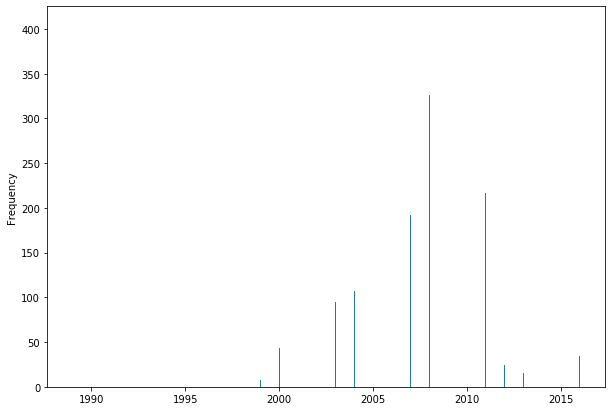

In [12]:
game_data_tbd = game_data.query('user_score == "tbd"')
game_data_tbd['year_of_release'].plot(kind = 'hist', bins = 1000,range = (1989,2016), figsize = (10,7))

Удалять строки со значениями TBD нельзя, так как мы потеряем существенное количество данных по продажам, которые могут повлиять на дальнейшие выводы. Так как рейтинг = 0 всего 1, предлагаю значение TBD заменить нулевыми значениями. 

In [13]:
game_data['user_score']= np.where((game_data.user_score =='tbd'), 0, game_data.user_score)

In [14]:
game_data['user_score'].value_counts()

0      2424
7.8     324
8       290
8.2     282
8.3     254
       ... 
0.7       2
0.6       2
0.5       2
0         1
9.7       1
Name: user_score, Length: 96, dtype: int64

In [15]:
game_data['user_score'] = game_data['user_score'].astype('float')  

In [16]:
game_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16713 non-null object
year_of_release    16713 non-null int64
genre              16713 non-null object
na_sales           16713 non-null float64
eu_sales           16713 non-null float64
jp_sales           16713 non-null float64
other_sales        16713 non-null float64
critic_score       8137 non-null float64
user_score         10014 non-null float64
rating             9949 non-null object
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


Создадим столбец total_sales для объединение общего суммарного значения продаж каждоый игры

In [17]:
game_data['total_sales'] = game_data['na_sales'] + game_data['eu_sales'] + game_data['jp_sales'] + game_data['other_sales'] 

In [18]:
game_data.head(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


In [19]:
game_data['rating'].isna().sum()

6764

In [20]:
game_data['rating'] = game_data['rating'].fillna('0+') 

In [22]:
game_data['rating'].isna().sum()

0

In [21]:
game_data['rating'].value_counts() 

0+      6764
E       3990
T       2961
M       1563
E10+    1420
EC         8
RP         3
K-A        3
AO         1
Name: rating, dtype: int64

<div style="border:solid blue 2px; padding: 20px"> <b>Вывод:</b><br>
 
    
1. Наименования столбцов были приведены к нижнему регистру.
2. Была проведена проверка на наличие дубликатов - они отсутствуют
3. Значени столбца с годом приведен в формат int, а столбце с пользовательским рейтингом приведен в формат float. Значения tbd имеется большое количество (т.е. рейтинг уточняется). Соответственно удалять такие значения нельзя. Это приведет к искажению дальнейшего анализа данных. Было принято заменить такие значения на нулевые. Пропуски не стал заменять на средние и медианные значения. С моей точки зрения это некорректно, так как нельзя привязаться к конкретной категории или группе игр. Все игры разные и пользователи оценивают их индивидуально.
4. Был сделан новый столбец total_sales - это суммарный объем продаж отдельно взятой игры
</div>

## Исследовательский анализ данных
### Построим гистограмму продаж игр по годам

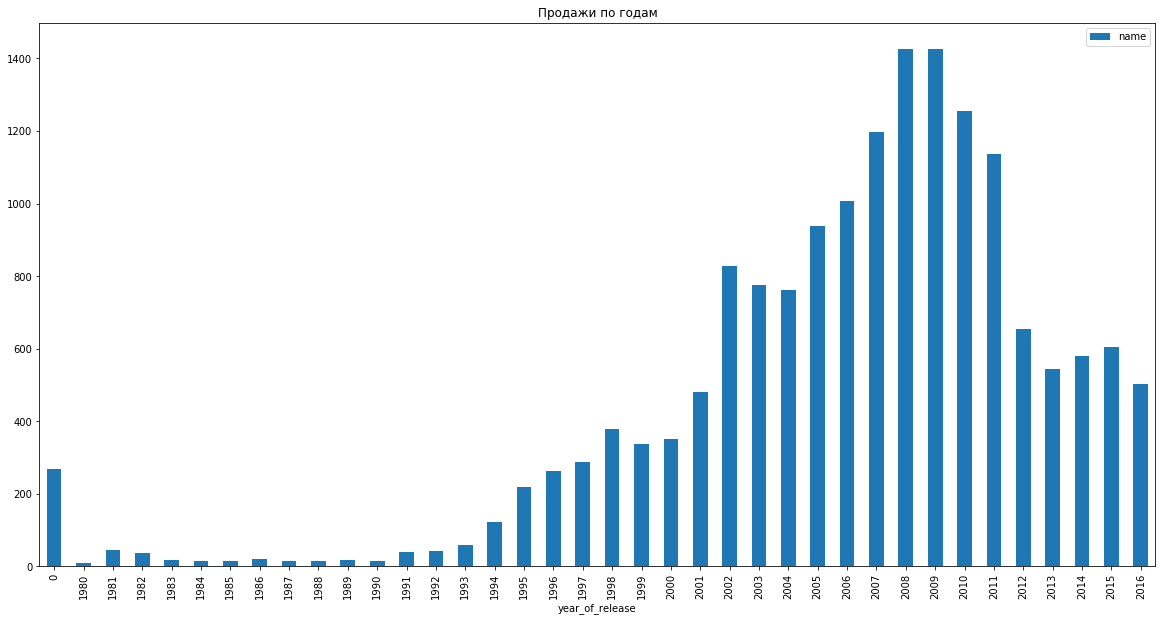

In [23]:
game_data_years = game_data.groupby('year_of_release').agg({'name':'count'}).reset_index()
game_data_years.plot(kind = 'bar', x = 'year_of_release', y = 'name', title = 'Продажи по годам', figsize = (20,10))


Вывод: Рост продаж компьютерных игр начинается после 2001 года и не падал ниже это отметки. Поэтому данные до 2001 года можно отбросить и взять анализируемый период в 15 лет

### Построим гистограмму продаж игр по платформам

In [24]:
game_data_platform = game_data.groupby(['platform','year_of_release']).agg({'total_sales':'sum'}).reset_index().set_index('platform').query('year_of_release>=2000')
game_data_platform.sort_values(by = 'total_sales', ascending = False).head(5)

,year_of_release,total_sales
platform,,
PS2,2004,211.81
Wii,2009,206.97
PS2,2002,205.38
PS2,2003,184.31
Wii,2008,171.32


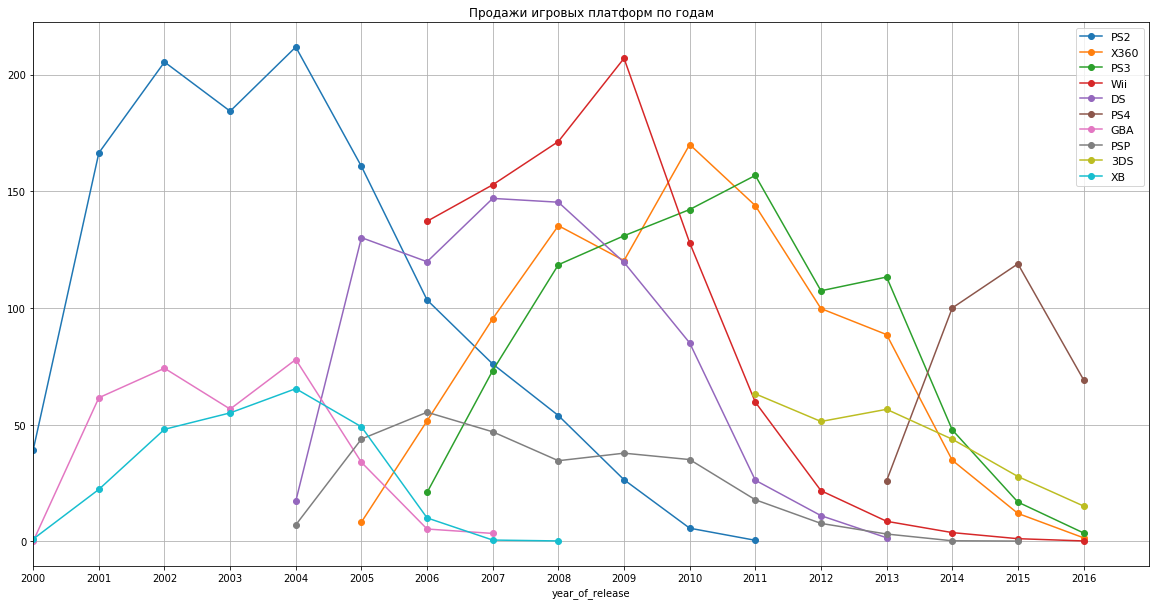

In [25]:
fig, ax = plt.subplots(figsize =(20,10))
game_data_platform_years= game_data_platform.groupby('platform').agg({'total_sales':'sum'}).sort_values(by = 'total_sales', ascending = False).head(10).index
#game_data_platform_years.plot(kind = 'bar', x = 'platform', y = 'total_sales', title = 'Продажи по годам', figsize = (20,10))
for platform in game_data_platform_years:
    game_data_platform.loc[platform].plot(style = '-o', xlim = (2000,2016), title = 'Продажи игровых платформ по годам', x = 'year_of_release', y ='total_sales', grid = True, ax=ax)
ax.legend(game_data_platform_years,prop = {'size':11})
ax.set_xlim([2000,2017])
ax.set_xticks(np.arange(2000,2017))
ax.set_xticklabels(range(2000,2017))
plt.show()
plt.show()


Построим график продаж всех платформ за выбранный актуальный период для прогнозирования продаж на 2017 год.


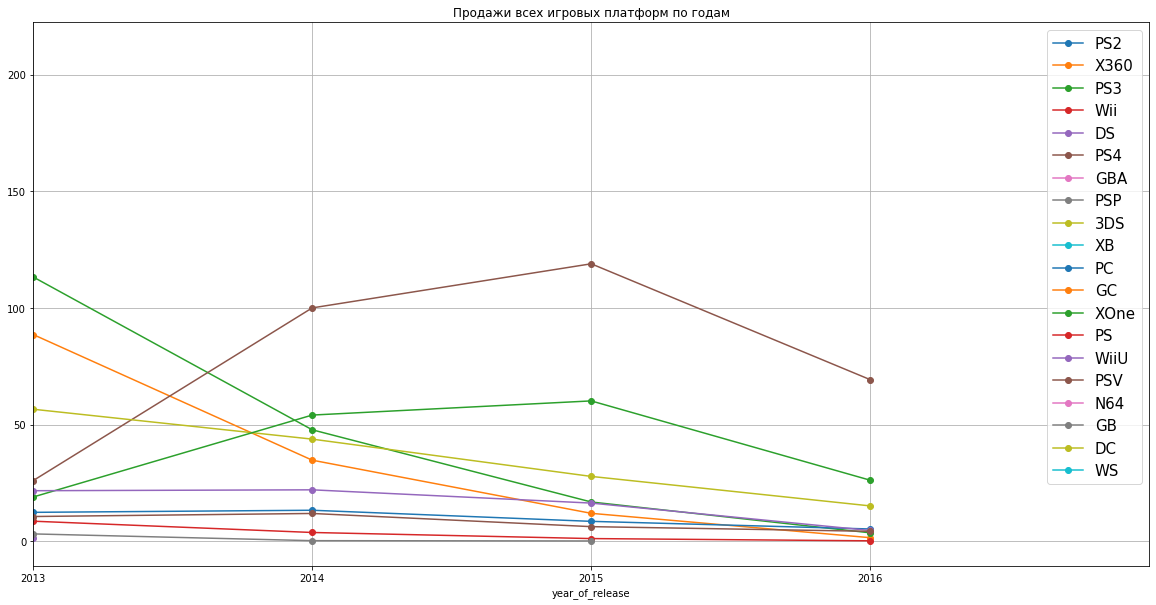

In [26]:
fig, ax = plt.subplots(figsize =(20,10))
game_data_platform_years_all= game_data_platform.groupby('platform').agg({'total_sales':'sum'}).sort_values(by = 'total_sales', ascending = False).index
#game_data_platform_years.plot(kind = 'bar', x = 'platform', y = 'total_sales', title = 'Продажи по годам', figsize = (20,10))
for platform in game_data_platform_years_all:
    game_data_platform.loc[platform].plot(style = '-o', xlim = (2013,2016), title = 'Продажи всех игровых платформ по годам', x = 'year_of_release', y ='total_sales', grid = True, ax=ax)
ax.legend(game_data_platform_years_all,prop = {'size':15})
ax.set_xlim([2013,2017])
ax.set_xticks(np.arange(2013,2017))
ax.set_xticklabels(range(2013,2017))
plt.show()
plt.show()


Выведем суммы продаж за 2016 год по всем платформам.


In [27]:
game_data_platform.loc[game_data_platform['year_of_release'] == 2016].sort_values(by = 'total_sales', ascending = False)

,year_of_release,total_sales
platform,,
PS4,2016,69.25
XOne,2016,26.15
3DS,2016,15.14
PC,2016,5.25
WiiU,2016,4.60
PSV,2016,4.25
PS3,2016,3.60
X360,2016,1.52
Wii,2016,0.18



 
На графике видно, что жизненный цикл платформ примерно одинаковый 8 - 11 лет.
Активное появление платформ началось с 2004 года по 2008 год
С 2013 года по 2016 ни одна игровая платформа не ушла срынка, однако у всех замечен спад продаж.

В период с 2013 года появилась новая платформа ps4 по ней до 2015 года был активный рост продаж, но к 2016 году, как и у всех платформ замечен спад продаж

Наиболее прибыльными с точки зрения продаж являются платформы ps4 и 3ds. Так как они находятся на среднем этапе своего жизненого цикла и согласно полученным данным, еще буду находиться на пике своей популярности достаточное количество времени (от 2-ух до 5 лет)


После общего анализа всех платформ, в наш список перспективных платформ необходимо добавить XOne. Так как с 2013 по 2016 наблюдался активный рост продаж. И в 2016 году игровая платформа XOne находится на 2 позиции по объему проданных игр.


### Построим график «ящик с усами»

In [28]:
# Сделаем срез данных по актуальному диапазону
game_data_query = game_data.query('year_of_release >= 2013')
game_data_query['year_of_release'].value_counts()

2015    606
2014    581
2013    544
2016    502
Name: year_of_release, dtype: int64

(0, 0.26)

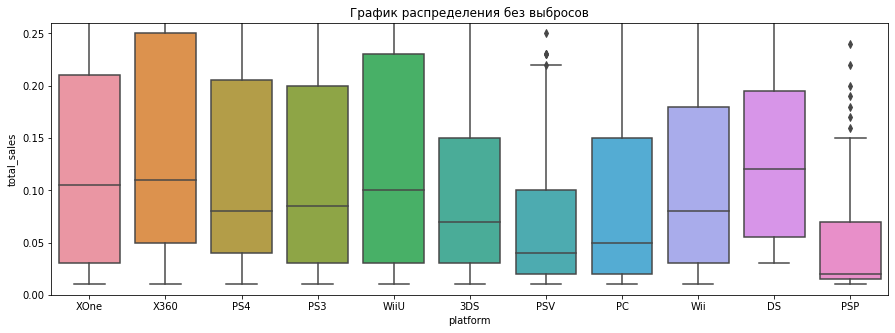

In [29]:
# Построим график "ящик с усиками"
import seaborn as sns
top_quantile = game_data_query['total_sales'].quantile(0.75)
low_quantile = game_data_query['total_sales'].quantile(0.25)
threshold = top_quantile + 2*low_quantile
fig, ax = plt.subplots(figsize =(15,5))
sns.boxplot(x = 'platform', 
            y = 'total_sales',
            data = game_data_query.query('total_sales <= @threshold'),ax=ax,)
plt.title("График распределения без выбросов")
plt.ylim(0,0.26)

Text(0.5, 1.0, 'График распределения с выбросами')

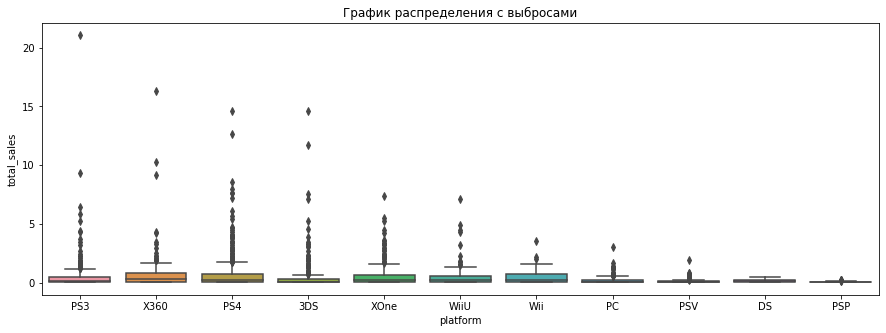

In [51]:
# Построим график "ящик с усиками"
fig, ax = plt.subplots(figsize =(15,5))
sns.boxplot(x = 'platform', 
            y = 'total_sales',
            data = game_data_query,ax=ax,)
plt.title("График распределения с выбросами")
#plt.ylim(0,0.26)

Вывод: у большей части платформ продажи находятся выше медианного значения. Наиболее равномерно распределены значения у платформы xone, ds 

### Анализ жанров по продажам

In [31]:
# Сгруппируем данные по по жанру и продажам.
game_data_genre = game_data_query.groupby('genre').agg({'name':'count', 'total_sales':['sum','median','mean']})
game_data_genre.columns = ['count','sum','median','mean']
game_data_genre.sort_values(by = 'sum', ascending = False)

,count,sum,median,mean
genre,,,,
Action,766,321.87,0.110,0.420196
Shooter,187,232.98,0.450,1.245882
Sports,214,150.65,0.240,0.703972
Role-Playing,292,145.89,0.125,0.499623
Misc,155,62.82,0.100,0.405290
Platform,74,42.63,0.225,0.576081
Racing,85,39.89,0.120,0.469294
Fighting,80,35.31,0.125,0.441375
Adventure,245,23.64,0.030,0.096490


Вывод: самым популярным жанром является экшн. Однако игр, выпущенных в жанре шутер меньше в 4 раза, Одна игра в среднем приносит намного больше выручки. Это можно понять по среднему и медианному значению. Так же не уступает по объему продаж, среднему и медианному значению - это жанр спорт.
Если рассматривать дальнейшую разработку игр, более выгодно вкладываться в игровые жанры шутер и спорт

### Влияние рейтинга игры на продажи

Text(0.5, 1.0, 'Рейтинг критиков')

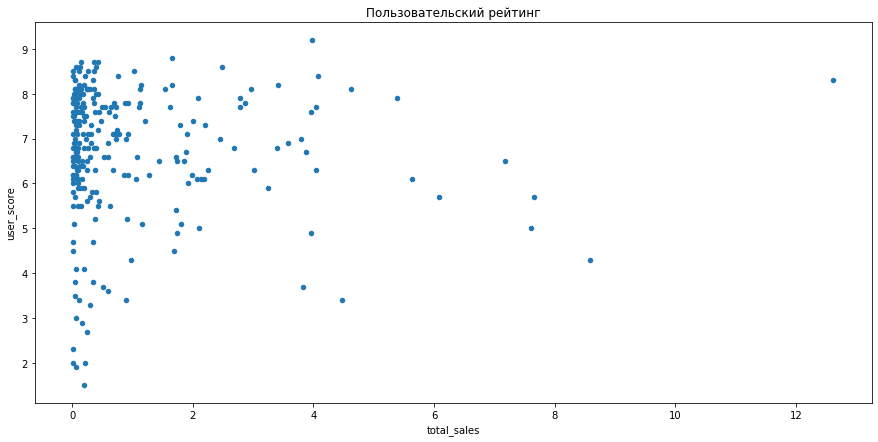

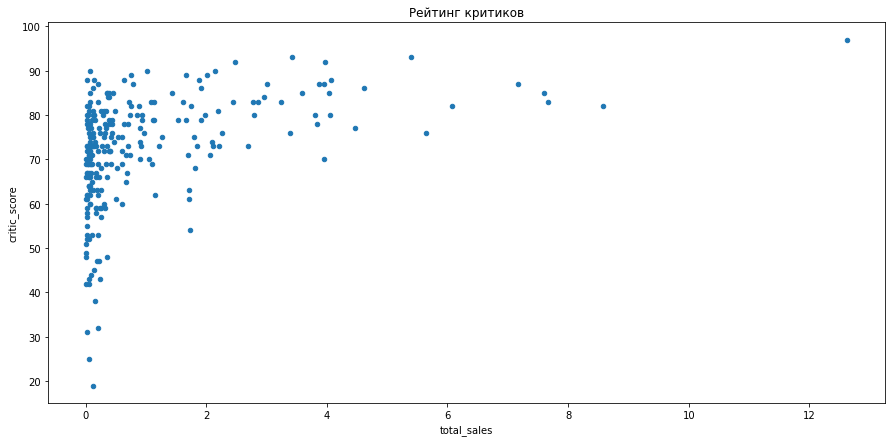

In [32]:
# Сдедаем срез данных по рейтингу. Отбросим нулевые значения.
data_user_score = game_data_query.query('user_score > 0 & platform == "PS4"').plot.scatter(
                      x='total_sales',
                      y='user_score',
                     figsize = (15,7))
plt.title("Пользовательский рейтинг")
data_critic_score = game_data_query.query('critic_score > 0 & platform == "PS4"').plot.scatter(
                      x='total_sales',
                      y='critic_score',
                      figsize = (15,7))
plt.title("Рейтинг критиков")

In [33]:
data_user_score = game_data_query.query('user_score > 0 & platform == "PS4"')
data_critic_score = game_data_query.query('critic_score > 0 & platform == "PS4"')
display(data_user_score['user_score'].corr(data_user_score['total_sales']))
display(data_critic_score['critic_score'].corr(data_critic_score['total_sales']))

-0.031957110204556424

0.40656790206178095

In [34]:
game_data_query['user_score'].corr(game_data_query['total_sales'])

0.09310898029039405

In [35]:
game_data_query['critic_score'].corr(game_data_query['total_sales'])

0.3136995151027369

Вывод: Значительный вес в продажи вносит мнение критиков. Корреляция имеет положителный знак.

Как показывает анализ пользователей платформы PS4, рейтинг пользователь в меньшей степени влияет на объем продаж.

## Портрет клиента по регионам

### Самые популярные платформы

In [36]:
rating_pivot_table = game_data_query.pivot_table(index = 'platform', values = ['na_sales','jp_sales','eu_sales'], aggfunc = ['sum'])

In [37]:
rating_pivot_table.columns = ['na_sales','jp_sales','eu_sales']

In [38]:
top5_eu = rating_pivot_table.sort_values(by = 'eu_sales', ascending = False).index[:5]
top5_jp = rating_pivot_table.sort_values(by = 'jp_sales', ascending = False).index[:5]
top5_na = rating_pivot_table.sort_values(by = 'na_sales', ascending = False).index[:5]

In [39]:
list_of_top = [top5_eu,top5_jp,top5_na]
for count,top in enumerate(list_of_top):
    if count == 0: 
        print('Топ платформ для европейского региона:',*top)
    elif count == 1:
        print('Топ платформ для японского региона:',*top)
    elif count == 2:
        print('Топ платформ для северо-американского региона:',*top)
    print()
    for platform in top:
        data = rating_pivot_table.loc[platform,['na_sales','jp_sales','eu_sales']]
        if count == 0: 
            part = data['eu_sales']
            sum_r = game_data_query['eu_sales'].sum()
        elif count == 1:
            part = data['jp_sales']
            sum_r = game_data_query['jp_sales'].sum()
        elif count == 2:
            part = data['na_sales']
            sum_r = game_data_query['na_sales'].sum()
        ratio = part / sum_r
        print('Рассмотрим подробнее следующую платформу: ',platform)
        print('Доля продаж',ratio)
        print()

Топ платформ для европейского региона: PS4 XOne X360 PS3 3DS

Рассмотрим подробнее следующую платформу:  PS4
Доля продаж 0.2772352956173676

Рассмотрим подробнее следующую платформу:  XOne
Доля продаж 0.237411722713714

Рассмотрим подробнее следующую платформу:  X360
Доля продаж 0.20819417178696176

Рассмотрим подробнее следующую платформу:  PS3
Доля продаж 0.16189480661856576

Рассмотрим подробнее следующую платформу:  3DS
Доля продаж 0.09739183642250716

Топ платформ для японского региона: 3DS PS3 PSV PS4 WiiU

Рассмотрим подробнее следующую платформу:  3DS
Доля продаж 0.4816735331723258

Рассмотрим подробнее следующую платформу:  PS3
Доля продаж 0.16586162807216942

Рассмотрим подробнее следующую платформу:  PSV
Доля продаж 0.13205000710328227

Рассмотрим подробнее следующую платформу:  PS4
Доля продаж 0.11336837618979946

Рассмотрим подробнее следующую платформу:  WiiU
Доля продаж 0.07728370507174308

Топ платформ для северо-американского региона: PS4 PS3 XOne X360 3DS

Рассмотрим 

На европейском и американском рынке в топ 5 находятся одинаковые платформы, на японском рынке место платформы XOne X360
появляются другие платформы WiiU и PSV. 

### Самый популярный жанр

In [40]:
top_genre_pivot_table = game_data_query.pivot_table(index = ['genre'], values = ['na_sales','jp_sales','eu_sales'], aggfunc = ['sum'])

In [41]:
top_genre_pivot_table.columns = ['na_sales','jp_sales','eu_sales']

In [42]:
top5_genres_eu = top_genre_pivot_table.sort_values(by = 'eu_sales', ascending = False).index[:5]
top5_genres_jp = top_genre_pivot_table.sort_values(by = 'jp_sales', ascending = False).index[:5]
top5_genres_na = top_genre_pivot_table.sort_values(by = 'na_sales', ascending = False).index[:5]

In [43]:
display('Топ 5 самых популярных жанров в европейском регионе:',*top5_genres_eu)
display('Топ 5 самых популярных жанров в японском регионе:',*top5_genres_jp)
display('Топ 5 самых популярных жанров в северо авереканском регионе:',*top5_genres_na)

'Топ 5 самых популярных жанров в европейском регионе:'

'Action'

'Shooter'

'Sports'

'Role-Playing'

'Misc'

'Топ 5 самых популярных жанров в японском регионе:'

'Role-Playing'

'Action'

'Misc'

'Fighting'

'Shooter'

'Топ 5 самых популярных жанров в северо авереканском регионе:'

'Action'

'Shooter'

'Sports'

'Role-Playing'

'Racing'

Европейские игроки очень похожи по выбору жанра на северо-американских игроков. Единственное различие, европейские игроки больше предпочитают жанр 'Misc чем 'Racing'.
Японские игроки немного отличаются от рассматриваемых регионов и на первое место поставили жанр 'Role-Playing'. В Европе и Америке на первое место поставили жанр 'Action'

### Влияние рейтинга  ESRB на продажи игр

In [44]:
esrb_pivot_table = game_data_query.pivot_table(index = ['rating'], values = ['na_sales','jp_sales','eu_sales'], aggfunc = ['sum'])

In [45]:
esrb_pivot_table.columns = ['eu_sales','jp_sales','na_sales']

In [46]:
esrb_pivot_table

,eu_sales,jp_sales,na_sales
rating,,,
0+,78.91,85.05,89.42
E,83.36,15.14,79.05
E10+,42.69,5.89,54.24
M,145.32,14.11,165.21
T,41.95,20.59,49.79


Да, рейтинг ESRB влияет на продажи в регионе, рейтинг в Европе и Америке влияет одинаково на продажи, наибольшие продажи с рейтингом M.
В Японии несколько иначе распределен рейтинг по продажам. Здесь первое место занимает рейтинг 0+

## Проверка гипотез
### Гипотеза №1

Нулевая гипотеза: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Альтернативная гипотеза : Средние пользовательские рейтинги платформ Xbox One и PC отличаются

In [47]:
alpha = 0.05
xone_var = game_data_query.query('platform == "XOne" & user_score > 0')['user_score']
pc_var = game_data_query.query('platform == "PC" & user_score > 0')['user_score']

results = st.ttest_ind(xone_var,pc_var)

display('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

'p-значение:'

0.14012658403611647

Не получилось отвергнуть нулевую гипотезу


In [48]:
xone_var.median(), pc_var.median()

(6.8, 6.8)

Вывод: в ходе тестирование нулевой гипотезы ее не удалось отвергуть. Так же, медианные значения двух платформ одинаковые, поэтому можно утверждать, что пользовательские рейтинги платформ Xbox One и PC одинаковые


### Гипотеза №2

Нулевая гипотеза: Средние пользовательские рейтинги жанров Action  и Sports одинаковые

Альтернативна гипотеза: Средние пользовательские рейтинги жанров Action и Sports разные.

In [49]:
action_var = game_data_query.query('genre == "Action" & user_score > 0')['user_score']
sports_var = game_data_query.query('genre == "Sports" & user_score > 0')['user_score']

results_2 = st.ttest_ind(action_var,sports_var)

display('p-значение:', results_2.pvalue)

if results_2.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

'p-значение:'

1.0517832389140023e-27

Отвергаем нулевую гипотезу


In [50]:
action_var.median(),sports_var.median()

(7.1, 5.5)

Вывод: в ходе тестирование нулевой гипотезы ее удалось отвергуть. Так же, медианные значения двух платформ отличаются, поэтому можно утверждать, что пользовательские рейтинги жанров Action и Sports отличаются

## Вывод


1. Если говорить о преобразовании и отчистке данных, то на вход к нам поступили относительно хорошие данные. Не пришлось делать
множество манипуляций по преобразованию. 
- Были заменены наименования столбцов на строчные
- Удалены строки, где не было названий игр
- Преобразован столбец с датой выхода игры

Удаление и замену пропусков в столбцах с рейтингом критиков и пользователей оставил без изменений. Преобразовал в тип float, чтобы была возможность проводить мат. операции со значениями. Далее, в ходе работы, делал срезы данных, в которых выводил рейтинг > 0

2. Для прогнозирование продаж на 2017 год был найден актуальный временной период (с 2013 по 2016 год). В этот период не наблюдалось появление новых платформ и ухода с рынка старых.
3. Было вывлено значительное снижение количество продаж по всем платформам, пик продаж был достигнут в период с 2008 по 2009 год. Сейчас до сих пор продолжается спад продаж. Единственный пик продаж был в момент выхода новой пдатформы PS4.
4. Жизненный цикл платформ примерно одинаковый 8 - 11 лет.
5. Активное появление платформ началось с 2004 года по 2008 год.
6. В период с 2013 года появилась новая платформа PS4 по ней до 2015 года был активный рост продаж, но к 2016 году, как и у всех платформ замечен спад.
7. Наиболее прибыльными с точки зрения продаж являются платформы PS4, XOne, 3DS. Так как они находятся на среднем этапе своего жизненого цикла и согласно полученным данным, еще буду находиться на пике своей популярности достаточное количество времени (от 2-ух до 5 лет)
8. Самым популярным жанром является экшн. Однако игр, выпущенных в жанре шутер меньше в 4 раза, но одна игра в среднем приносит намного больше выручки. Это можно понять по среднему и медианному значению. Так же не уступает по объему продаж, среднему и медианному значению - это жанр спорт.

Если рассматривать дальнейшую разработку игр, более выгодно вкладываться в игровые жанры шутер и спорт (но необходимо учитывать себестоимость разработки в каждом их жанров, поэтому это поверхностный вывод, который требует более детального анализа)

# ПОРТРЕТ КЛИЕНТА
- Топ платформ для европейского региона: PS4 XOne X360 PS3 3DS
- Топ платформ для японского региона: 3DS PS3 PSV PS4 WiiU
- Топ платформ для северо-американского региона: PS4 PS3 XOne X360 3DS

    На европейском и американском рынке в топ 5 находятся одинаковые платформы, на японском рынке вместо платформ XOne X360
появляются другие платформы WiiU и PSV. 
Преобладающее большиство продаж находится на европейском рынке

    Европейские игроки очень похожи по выбору жанра на северо-американских игроков. Единственное различие, европейские игроки больше предпочитают жанр 'Misc чем 'Racing'.
Японские игроки немного отличаются от рассматриваемых регионов и на первое место поставили жанр 'Role-Playing'. В Европе и Америке на первое место поставили жанр 'Action'

# Подтвержденные гипотезы:

1. Пользовательские рейтинги платформ Xbox One и PC одинаковые
2. Пользовательские рейтинги жанров Action и Sports отличаются